In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/xlabels_mechanics.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/X_mechanics.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     a_ventricles  a_atria   EDP_lv   EDP_rv
0         4.55728  3.68805  6.30434  6.88496
1         4.77565  3.37159  7.40547  6.83182
2         3.44083  4.10285  6.99799  1.66170
3         3.00760  3.08643  2.90710  5.82416
4         3.20078  2.19295  6.15502  3.05678
..            ...      ...      ...      ...
995       2.31175  3.96805  4.79704  6.54769
996       3.06559  4.27542  6.57854  4.39223
997       1.28976  4.76784  5.42560  4.53470
998       2.92803  2.80237  1.76374  5.95269
999       1.55451  3.02115  3.78612  5.67230

[1000 rows x 4 columns]


In [3]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/output_mask_beat_5.txt',index_col=None,delim_whitespace=True,header=None)

In [4]:
np.sum(mask)

0    92
dtype: int64

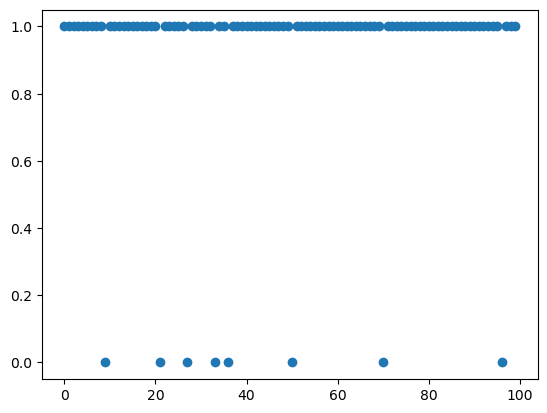

In [5]:
plt.plot(mask,'o')

In [6]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_8/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   150.31   7.59  106.81   92.15       1709       -746  145.58   2.73   
1   147.43   7.84  103.98   92.29       1738       -756  147.94   2.76   
2   145.90   7.62   97.99   98.28       1898       -809  176.16   2.22   
3   164.96   6.72  119.94   94.06       1639       -715  137.95   2.56   
4   150.50   7.50  101.49  101.29       1929       -830  166.26   2.41   
..     ...    ...     ...     ...        ...        ...     ...    ...   
87  148.17   7.71  104.09   93.23       1751       -766  147.29   2.75   
88  148.90   6.50   99.34  103.19       1971       -830  152.27   2.36   
89  143.21   6.28   92.21  106.58       2116       -862  153.69   2.34   
90  147.41   7.47  102.58   94.11       1787       -780  153.45   2.58   
91  169.99   6.34  119.20  102.84       1834       -811  163.38   2.24   

     RVesv  RVpMax  ...  RAvMax  RApMax  LAsvA  LAinflV  LAsvV  RAsvA  \
0   105.29   24.05  ...   89.21    3.1

In [7]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [10]:
model.fit(input_masked.values, mask.values.squeeze())

LogisticRegression(random_state=0, solver='liblinear')

In [11]:
reps=50
fail_score = 0
success_score = 0

for j in range(reps):
    complete_input_train=input_complete.sample(6)
    complete_output_train=mask.loc[complete_input_train.index]
    complete_input_test = input_complete.loc[~input_complete.index.isin(complete_input_train.index)]
    complete_output_test = mask.loc[complete_input_test.index]
    for i in range(input_failed.shape[0]):
   
        fail_input_test = input_failed.iloc[[i]]
        fail_output_test = mask.loc[fail_input_test.index]
        fail_input_train=input_failed.loc[~input_failed.index.isin(fail_input_test.index)]
        fail_output_train=mask.loc[fail_input_train.index]

        y_train = pd.concat([fail_output_train,complete_output_train])
        y_test = pd.concat([fail_output_test,complete_output_test])

        x_train = pd.concat([fail_input_train,complete_input_train])
        x_test= pd.concat([fail_input_test,complete_input_test])

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x_train.values, y_train.values.squeeze())

        success_score+=(1-model.predict(fail_input_test.values))/input_failed.shape[0]/reps
        fail_score+=model.score(complete_input_test.values,complete_output_test.values.squeeze())/reps/input_failed.shape[0]

In [12]:
success_score

array([0.965])

In [13]:
fail_score

0.8116279069767434

In [14]:
nDim = x_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(x_train.iloc[:,i]),np.max(x_train.iloc[:,i])])
    print(boundsMaxMin[i])
    

[1.1861, 4.96027]
[1.03657, 4.29867]
[1.61648, 7.02555]
[1.15945, 6.97759]


In [15]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = param_values
#data1.columns = X_train.columns

Ymean=model.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_81238/2588839841.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [16]:
Ymean.shape

(10240,)

In [17]:
np.sum(Ymean)

7557

In [18]:
Si = []
nMod = y_train.shape[1]
nDim = x_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean, print_to_console=True,calc_second_order=True))

                       ST   ST_conf
(a_ventricles,)  0.035904  0.018819
(a_atria,)       0.592414  0.065975
(EDP_lv,)        0.235940  0.044545
(EDP_rv,)        0.759111  0.065956
                       S1   S1_conf
(a_ventricles,) -0.000246  0.017417
(a_atria,)       0.218716  0.064006
(EDP_lv,)        0.025153  0.042285
(EDP_rv,)        0.370753  0.070649
Empty DataFrame
Columns: [S2, S2_conf]
Index: []


In [19]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

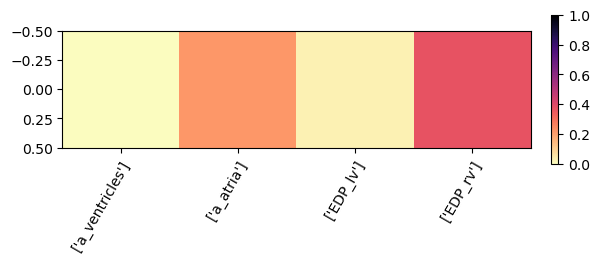

In [20]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

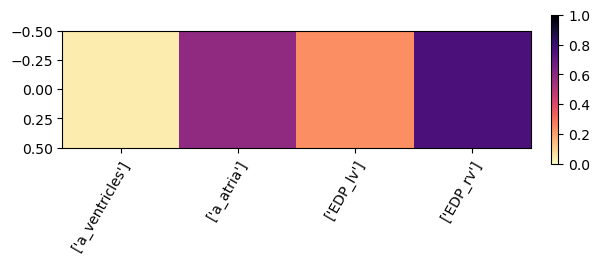

In [21]:
inputs = x_labels.values.tolist()

fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:10],cmap='magma_r',vmin=0,vmax=1)


ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [22]:
data2=data1[::20]

Text(0.5, 0, 'EDP_lv')

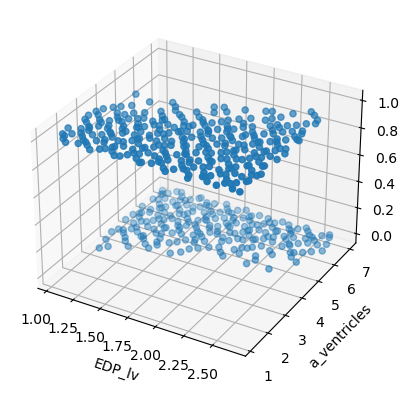

In [23]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data2[:,1],data2[:,3],model.predict(data2))
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

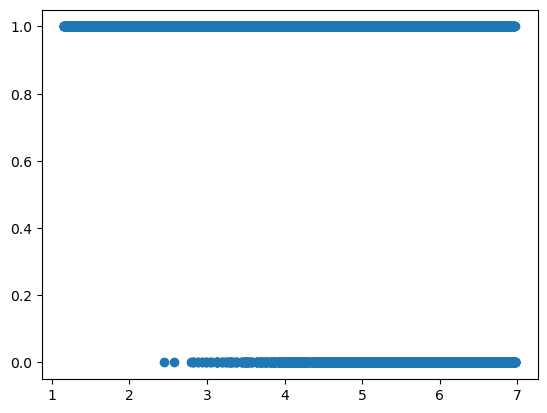

In [24]:
plt.plot(data1[:,3],model.predict(data1),'o')

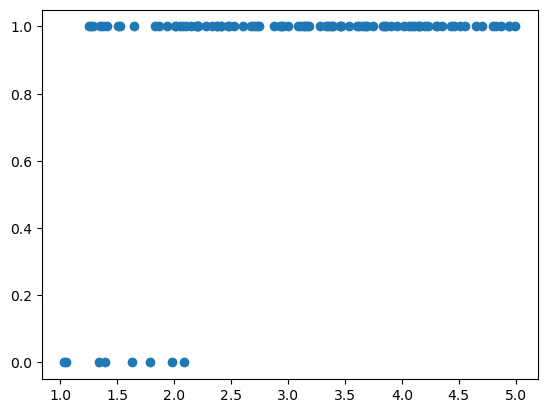

In [25]:
plt.plot(input_masked.iloc[:,1],mask,'o')

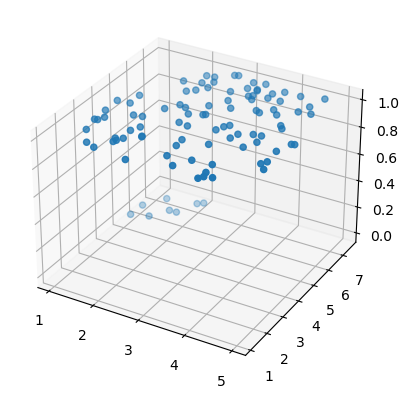

In [26]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(input_masked.iloc[:,1],input_masked.iloc[:,3],mask)

# Emulator

In [27]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [28]:
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [29]:
input_masked.shape

(92, 4)

In [30]:
y_all.shape

(92, 28)

In [31]:
y_all.index[0]

0

In [32]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,150.31,7.59,106.81,92.15,1709,-746,145.58,2.73,105.29,24.05,...,89.21,3.16,13.26,8.41,12.64,9.54,9.92,11.27,94.893,115.487
1,147.43,7.84,103.98,92.29,1738,-756,147.94,2.76,107.50,24.18,...,89.66,3.20,13.34,8.39,12.52,9.80,10.23,11.69,94.079,115.342
2,145.90,7.62,97.99,98.28,1898,-809,176.16,2.22,127.83,25.91,...,106.78,2.86,13.75,9.53,12.34,11.58,12.59,14.40,94.397,114.220
3,164.96,6.72,119.94,94.06,1639,-715,137.95,2.56,96.00,24.05,...,88.33,3.07,16.15,8.93,13.82,10.04,10.41,12.21,95.891,116.615
4,150.50,7.50,101.49,101.29,1929,-830,166.26,2.41,117.83,25.68,...,101.83,3.10,17.65,9.84,14.21,13.17,13.86,16.77,93.581,114.832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,148.17,7.71,104.09,93.23,1751,-766,147.29,2.75,106.02,24.35,...,89.91,3.22,13.65,8.47,12.50,10.21,10.30,11.88,94.022,115.275
88,148.90,6.50,99.34,103.19,1971,-830,152.27,2.36,104.59,25.45,...,97.75,3.01,13.68,9.52,12.67,10.81,10.89,12.09,93.988,115.965
89,143.21,6.28,92.21,106.58,2116,-862,153.69,2.34,104.28,25.54,...,99.59,3.07,14.93,9.81,12.95,12.26,11.65,13.10,93.677,117.133
90,147.41,7.47,102.58,94.11,1787,-780,153.45,2.58,110.68,24.68,...,95.10,3.07,12.55,8.63,12.00,10.11,10.23,11.60,93.945,114.816


In [33]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(input_masked.values)

In [34]:
y_train

tensor([[150.3100,   7.5900, 106.8100,  ...,  11.2700,  94.8930, 115.4870],
        [147.4300,   7.8400, 103.9800,  ...,  11.6900,  94.0790, 115.3420],
        [145.9000,   7.6200,  97.9900,  ...,  14.4000,  94.3970, 114.2200],
        ...,
        [143.2100,   6.2800,  92.2100,  ...,  13.1000,  93.6770, 117.1330],
        [147.4100,   7.4700, 102.5800,  ...,  11.6000,  93.9450, 114.8160],
        [169.9900,   6.3400, 119.2000,  ...,  17.3000,  95.9640, 114.6930]],
       dtype=torch.float64)

In [35]:
x_train.shape

torch.Size([92, 4])

In [36]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [37]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[1.03409, 4.99708]
[1.25589, 4.9957]
[1.15984, 7.49807]
[1.15945, 7.45172]


In [38]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_81238/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [39]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                       ST   ST_conf
(a_ventricles,)  0.164830  0.022802
(a_atria,)       0.009564  0.001163
(EDP_lv,)        0.885974  0.091268
(EDP_rv,)        0.056441  0.007921
                       S1   S1_conf
(a_ventricles,)  0.047735  0.043179
(a_atria,)       0.008822  0.008501
(EDP_lv,)        0.782515  0.076380
(EDP_rv,)        0.036268  0.018782
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                       ST   ST_conf
(a_ventricles,)  0.697222  0.061788
(a_atria,)       0.068397  0.006441
(EDP_lv,)        0.223744  0.021903
(EDP_rv,)        0.076948  0.011157
                       S1   S1_conf
(a_ventricles,)  0.650815  0.063123
(a_atria,)       0.063647  0.021305
(EDP_lv,)        0.202354  0.036137
(EDP_rv,)        0.022753  0.023354
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                       ST   ST_conf
(a_ventricles,)  0.140495  0.020459
(a_atria,)       0.002731  0.000343
(EDP_lv,)        0.799514  0.083175
(EDP_rv,)        0.204527  0.033539
  

                       ST   ST_conf
(a_ventricles,)  0.587159  0.067000
(a_atria,)       0.000190  0.000032
(EDP_lv,)        0.007898  0.001207
(EDP_rv,)        0.477472  0.056107
                       S1   S1_conf
(a_ventricles,)  0.518013  0.064725
(a_atria,)      -0.000090  0.001117
(EDP_lv,)        0.002917  0.006653
(EDP_rv,)        0.406785  0.054206
Empty DataFrame
Columns: [S2, S2_conf]
Index: []


In [40]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


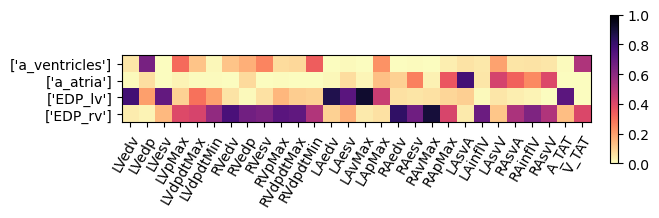

In [41]:
inputs = x_labels.values.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

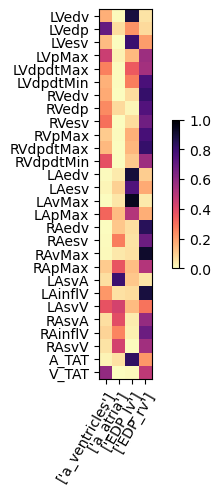

In [42]:
inputs = x_labels.values.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [43]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,150.31,7.59,106.81,92.15,1709,-746,145.58,2.73,105.29,24.05,...,89.21,3.16,13.26,8.41,12.64,9.54,9.92,11.27,94.893,115.487
1,147.43,7.84,103.98,92.29,1738,-756,147.94,2.76,107.50,24.18,...,89.66,3.20,13.34,8.39,12.52,9.80,10.23,11.69,94.079,115.342
2,145.90,7.62,97.99,98.28,1898,-809,176.16,2.22,127.83,25.91,...,106.78,2.86,13.75,9.53,12.34,11.58,12.59,14.40,94.397,114.220
3,164.96,6.72,119.94,94.06,1639,-715,137.95,2.56,96.00,24.05,...,88.33,3.07,16.15,8.93,13.82,10.04,10.41,12.21,95.891,116.615
4,150.50,7.50,101.49,101.29,1929,-830,166.26,2.41,117.83,25.68,...,101.83,3.10,17.65,9.84,14.21,13.17,13.86,16.77,93.581,114.832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,148.17,7.71,104.09,93.23,1751,-766,147.29,2.75,106.02,24.35,...,89.91,3.22,13.65,8.47,12.50,10.21,10.30,11.88,94.022,115.275
88,148.90,6.50,99.34,103.19,1971,-830,152.27,2.36,104.59,25.45,...,97.75,3.01,13.68,9.52,12.67,10.81,10.89,12.09,93.988,115.965
89,143.21,6.28,92.21,106.58,2116,-862,153.69,2.34,104.28,25.54,...,99.59,3.07,14.93,9.81,12.95,12.26,11.65,13.10,93.677,117.133
90,147.41,7.47,102.58,94.11,1787,-780,153.45,2.58,110.68,24.68,...,95.10,3.07,12.55,8.63,12.00,10.11,10.23,11.60,93.945,114.816


In [44]:
y_train

tensor([[150.3100,   7.5900, 106.8100,  ...,  11.2700,  94.8930, 115.4870],
        [147.4300,   7.8400, 103.9800,  ...,  11.6900,  94.0790, 115.3420],
        [145.9000,   7.6200,  97.9900,  ...,  14.4000,  94.3970, 114.2200],
        ...,
        [143.2100,   6.2800,  92.2100,  ...,  13.1000,  93.6770, 117.1330],
        [147.4100,   7.4700, 102.5800,  ...,  11.6000,  93.9450, 114.8160],
        [169.9900,   6.3400, 119.2000,  ...,  17.3000,  95.9640, 114.6930]],
       dtype=torch.float64)

In [45]:
y_all.copy().drop(y_all.index[i]).values

array([[150.31 ,   7.59 , 106.81 , ...,  11.27 ,  94.893, 115.487],
       [147.43 ,   7.84 , 103.98 , ...,  11.69 ,  94.079, 115.342],
       [145.9  ,   7.62 ,  97.99 , ...,  14.4  ,  94.397, 114.22 ],
       ...,
       [143.21 ,   6.28 ,  92.21 , ...,  13.1  ,  93.677, 117.133],
       [147.41 ,   7.47 , 102.58 , ...,  11.6  ,  93.945, 114.816],
       [169.99 ,   6.34 , 119.2  , ...,  17.3  ,  95.964, 114.693]])

In [50]:
nsamp=100
MSE = np.zeros((y_all.shape[0],y_all.shape[1]))

for i in range(y_all.shape[0]):
    y_train = torch.tensor(y_all.copy().drop(y_all.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_all.index[i]).values)
    
    y_test = torch.tensor(y_all.loc[[y_all.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_all.index[i]]].values)
    
    
    
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [51]:
1-MSE.mean(axis=0)/np.var(y_all,axis=0)

LVedv        0.997377
LVedp        0.996837
LVesv        0.997530
LVpMax       0.995499
LVdpdtMax    0.997525
LVdpdtMin    0.995713
RVedv        0.998372
RVedp        0.997341
RVesv        0.997961
RVpMax       0.995137
RVdpdtMax    0.991276
RVdpdtMin    0.994810
LAedv        0.993796
LAesv        0.992412
LAvMax       0.994452
LApMax       0.992207
RAedv        0.999049
RAesv        0.998510
RAvMax       0.999165
RApMax       0.987309
LAsvA        0.996094
LAinflV      0.993560
LAsvV        0.994251
RAsvA        0.995909
RAinflV      0.998732
RAsvV        0.998524
A_TAT        0.969831
V_TAT        0.989649
dtype: float64

In [52]:
MSE.shape

(92, 28)

In [53]:
MSE[0].shape

(28,)

In [54]:
np.var(y_all,axis=0).shape

(28,)

In [55]:
R2=np.zeros((18,28))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_all,axis=0))

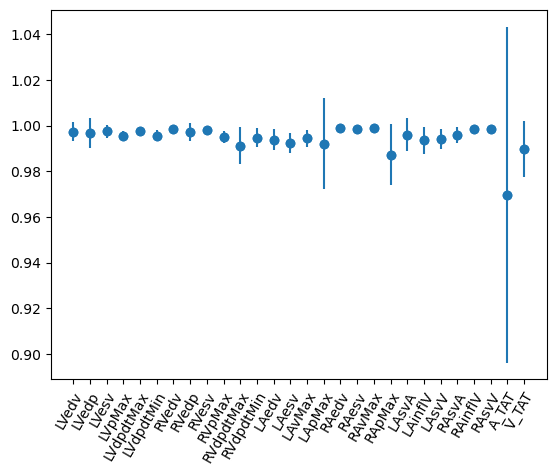

In [56]:
fig, ax = plt.subplots()


ax.scatter(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)))
plt.errorbar(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [48]:
y_calibration = y_all.loc[:,['V_TAT','A_TAT','LVpMax','LVedv','LVesv']]

In [49]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [50]:
y_calibration2=y_calibration.join(y_calibration2)

In [81]:
MSE = np.zeros((y_calibration.shape[0],y_calibration.shape[1]))

for i in range(y_calibration.shape[0]):
    y_train = torch.tensor(y_calibration.copy().drop(y_calibration.index[i]).values)
    X_train = torch.tensor(input_masked.copy().drop(y_calibration.index[i]).values)
    
    y_test = torch.tensor(y_calibration.loc[[y_calibration.index[i]]].values)
    X_test = torch.tensor(input_masked.loc[[y_calibration.index[i]]].values)
    print(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

tensor([[115.4870,  92.1500]], dtype=torch.float64)
0
1
tensor([[115.3420,  92.2900]], dtype=torch.float64)
0
1
tensor([[114.2200,  98.2800]], dtype=torch.float64)
0
1
tensor([[116.6150,  94.0600]], dtype=torch.float64)
0
1
tensor([[114.8320, 101.2900]], dtype=torch.float64)
0
1
tensor([[114.9940,  93.7400]], dtype=torch.float64)
0
1
tensor([[121.6470,  89.4400]], dtype=torch.float64)
0
1
tensor([[121.1410,  94.0900]], dtype=torch.float64)
0
1
tensor([[115.6010,  89.0100]], dtype=torch.float64)
0
1
tensor([[117.2650,  91.8500]], dtype=torch.float64)
0
1
tensor([[115.9390,  96.4300]], dtype=torch.float64)
0
1
tensor([[118.1300,  99.1200]], dtype=torch.float64)
0
1
tensor([[116.1400, 103.1300]], dtype=torch.float64)
0
1
tensor([[114.7940,  97.7400]], dtype=torch.float64)
0
1
tensor([[119.6630,  94.9100]], dtype=torch.float64)
0
1
tensor([[117.6090,  96.3400]], dtype=torch.float64)
0
1
tensor([[115.8330,  91.6800]], dtype=torch.float64)
0
1
tensor([[114.9780,  90.7500]], dtype=torch.float

In [82]:
R2=np.zeros((18,5))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_calibration,axis=0))

ValueError: could not broadcast input array from shape (2,) into shape (5,)

In [ ]:
R2.std(axis=0)

In [ ]:
plt.plot(np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),'o')

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
fig, ax = plt.subplots()


ax.scatter(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)))
plt.errorbar(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
X_train = torch.tensor(input_masked.values)

In [67]:
y_train=torch.tensor(y_calibration.values)

In [68]:
X_train

tensor([[4.5573, 3.6881, 6.3043, 6.8850],
        [4.7756, 3.3716, 7.4055, 6.8318],
        [3.4408, 4.1029, 6.9980, 1.6617],
        [3.0076, 3.0864, 2.9071, 5.8242],
        [3.2008, 2.1930, 6.1550, 3.0568],
        [4.3187, 3.2820, 4.7652, 5.4308],
        [1.2800, 2.3750, 3.7305, 6.9900],
        [1.3298, 4.2049, 6.6586, 7.1618],
        [4.4734, 4.0166, 1.1598, 5.9863],
        [3.0222, 3.8606, 3.8693, 7.1650],
        [3.2531, 2.1989, 4.2106, 5.7331],
        [1.9997, 3.4562, 6.4813, 6.2412],
        [2.1961, 1.5113, 4.8919, 4.7809],
        [3.9334, 1.2727, 3.1507, 3.4429],
        [1.2620, 2.8746, 2.8987, 5.2446],
        [1.8505, 4.5062, 2.9268, 5.0457],
        [4.2454, 4.6544, 5.9401, 7.3796],
        [4.9603, 4.1521, 1.6165, 4.3160],
        [2.2401, 3.1140, 4.8514, 2.9955],
        [2.9630, 1.9337, 5.7741, 6.2838],
        [2.9103, 2.6768, 2.4572, 7.4024],
        [4.8520, 3.3527, 3.9171, 6.8986],
        [2.3895, 1.2896, 2.6254, 2.7953],
        [2.4062, 4.7994, 4.6290, 2

In [46]:
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

NameError: name 'X_train' is not defined

In [70]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([torch.min(X_train[:,i]).detach().numpy(),torch.max(X_train[:,i]).detach().numpy()])
    print(boundsMaxMin[i])

[array(1.03409), array(4.99708)]
[array(1.25589), array(4.9957)]
[array(1.15984), array(7.49807)]
[array(1.15945), array(7.45172)]


In [71]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_2948/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [72]:
Si = []
nMod = y_train.shape[1]
nDim = X_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                       ST   ST_conf
(a_ventricles,)  0.587122  0.057191
(a_atria,)       0.000189  0.000033
(EDP_lv,)        0.007903  0.001076
(EDP_rv,)        0.477534  0.051396
                       S1   S1_conf
(a_ventricles,)  0.517950  0.070660
(a_atria,)      -0.000090  0.001124
(EDP_lv,)        0.002918  0.007363
(EDP_rv,)        0.406818  0.055730
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                       ST   ST_conf
(a_ventricles,)  0.019548  0.003398
(a_atria,)       0.061992  0.007713
(EDP_lv,)        0.826716  0.071444
(EDP_rv,)        0.218067  0.023050
                       S1   S1_conf
(a_ventricles,)  0.007308  0.011777
(a_atria,)      -0.001100  0.022928
(EDP_lv,)        0.722051  0.066303
(EDP_rv,)        0.133210  0.035646
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                       ST   ST_conf
(a_ventricles,)  0.452526  0.049294
(a_atria,)       0.023784  0.002231
(EDP_lv,)        0.145980  0.021061
(EDP_rv,)        0.558909  0.078291
  

In [73]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


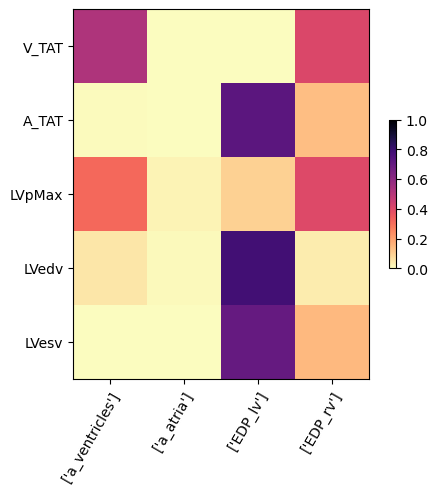

In [74]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

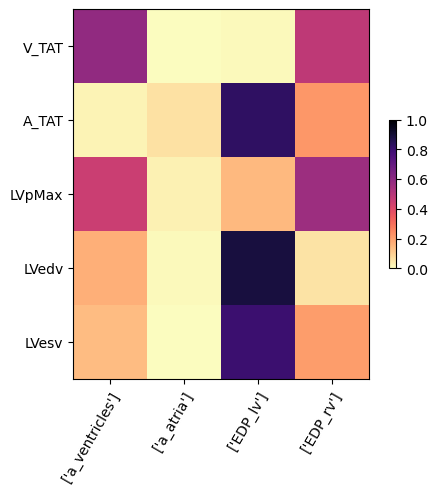

In [75]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [76]:
emulator.predict(data1).detach().numpy()[:,4]

array([115.489975, 110.77045 , 114.35486 , ...,  98.04625 , 117.783226,
       114.68604 ], dtype=float32)

IndexError: index 4 is out of bounds for dimension 1 with size 4

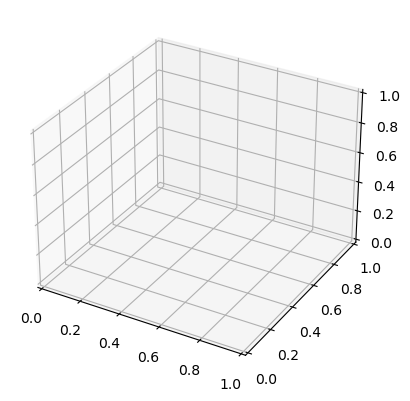

In [77]:
fig = plt.figure()
ax=fig.add_subplot(projection='3d')
ax.scatter(data1[:,4],data1[:,6],emulator.predict(data1).detach().numpy()[:,3])
plt.ylabel('a_ventricles')
plt.xlabel('EDP_lv')

In [ ]:
Si[i].to_df()

In [47]:
y_calibration

NameError: name 'y_calibration' is not defined

In [94]:
y_calibration = y_all.loc[:,['A_TAT','LVpMax']]

In [95]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [96]:
y_calibration=torch.tensor(y_calibration.join(y_calibration2).values)

In [97]:
emulator=GPE.ensemble(torch.tensor(input_masked.values),y_calibration,mean_func="linear",training_iter=500)

0
1
2


In [98]:
input_masked

,a_ventricles,a_atria,EDP_lv,EDP_rv
0,4.55728,3.68805,6.30434,6.88496
1,4.77565,3.37159,7.40547,6.83182
2,3.44083,4.10285,6.99799,1.66170
3,3.00760,3.08643,2.90710,5.82416
4,3.20078,2.19295,6.15502,3.05678
...,...,...,...,...
87,4.62090,3.39823,6.86218,6.48537
88,2.15338,4.31058,6.13458,4.35658
89,1.57269,3.46596,6.74494,4.01827
90,4.36780,4.42974,6.50104,5.20186


In [99]:
boundsMaxMin

[[1.03409, 4.99708], [1.25589, 4.9957], [1.15984, 7.49807], [1.15945, 7.45172]]

In [100]:
boundsMaxMin

[[1.03409, 4.99708], [1.25589, 4.9957], [1.15984, 7.49807], [1.15945, 7.45172]]

In [58]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [129]:
import emcee
ndim = nDim
nwalkers = 18
p0 = np.random.multivariate_normal(centre, 0.0001*np.identity(ndim), size=(nwalkers))
y_val = torch.tensor([134,133,0.6])

In [130]:
boundsMaxMin

[[1.03409, 4.99708], [1.25589, 4.9957], [1.15984, 7.49807], [1.15945, 7.45172]]

In [131]:
np.array(boundsMaxMin)[:,0]*2

array([2.06818, 2.51178, 2.31968, 2.3189 ])

In [132]:
p0[0]

array([3.01979838, 3.12569064, 4.3329791 , 4.29830824])

In [133]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]*0.5<theta).all() and (theta<np.array(boundsMaxMin)[:,1]*2).all():
        return 0.0
    return -np.inf

In [134]:
x=torch.tensor(p0[0])[None]
ll =np.sum(emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],0).detach().numpy())

In [135]:
def log_likelihood(x,emulator,y_val):
    x=torch.tensor(x)[None]
    ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],0)).detach().numpy())
    return ll

In [136]:
log_likelihood(p0[1],emulator,y_val)

-106721.69

In [137]:
def log_prob(theta, emulator,y_val):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta,emulator, y_val)

In [138]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [139]:
p0[0].shape

(4,)

In [140]:
torch.tensor(p0[0]).shape

torch.Size([4])

In [141]:
emulator.predict(torch.tensor(p0)).shape

torch.Size([18, 3])

In [142]:
for i in range(16):
    print(log_prob(p0[i],emulator,y_val))

-106576.375
-106721.6875
-106523.453125
-106596.328125
-106529.609375
-106348.8671875
-106462.796875
-106644.890625
-106506.9921875
-106762.734375
-106469.765625
-106561.9296875
-106676.78125
-106573.8046875
-106638.75
-106497.515625


In [143]:
sampler.run_mcmc(p0, 40000)

State([[ 7.31390608  9.06655389  0.59268613 14.69465714]
 [ 7.98312104  9.5932706   0.59387232 14.89473141]
 [ 7.60510176  9.73240847  0.60342593 14.85038541]
 [ 9.78763103  9.37248294  0.58700322 14.77846077]
 [ 9.53117239  9.80399897  0.58301055 14.86648056]
 [ 9.64464623  9.97674569  0.60887629 14.56075536]
 [ 9.29444808  9.37287967  0.58113958 14.85405917]
 [ 9.19804758  9.40471733  0.63040631 14.85985104]
 [ 5.85962955  9.61186948  0.58629465 14.77178764]
 [ 9.89500437  9.47945526  0.58098258 14.87870929]
 [ 8.9382094   9.63239139  0.59866392 14.9013188 ]
 [ 8.24433978  9.62440444  0.58070731 14.73562197]
 [ 9.0475089   9.94049851  0.60157781 14.83460318]
 [ 9.50602317  9.77835303  0.58393279 14.79671501]
 [ 9.44331439  9.96272689  0.64522161 14.83937003]
 [ 7.51230425  9.93636047  0.58872342 14.81864685]
 [ 9.55392843  8.94467435  0.60884968 14.80845323]
 [ 7.93496203  9.95874018  0.68484254 14.61308509]], log_prob=[-1662.42529297 -1658.13964844 -1658.72937012 -1658.69238281
 -16

In [144]:
flat_samples = sampler.get_chain(discard=20000, thin=10, flat=True)
print(flat_samples.shape)

(36000, 4)


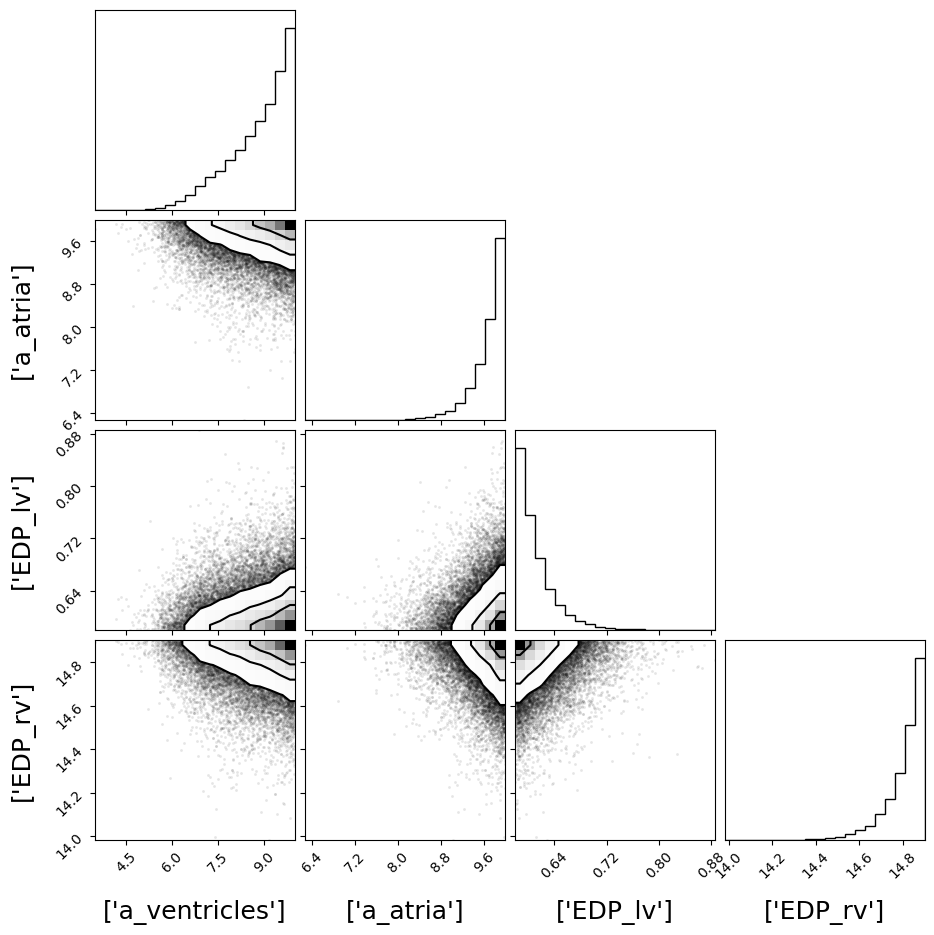

In [145]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [146]:
samp = pd.DataFrame(flat_samples).sample(50)

In [147]:
samp.to_csv("MCMC_samples_scenario_8_60_2timesUpper.dat", sep = " ",index=False,header=None)

In [148]:
flat_samples.mean(axis=0)

array([ 8.81213747,  9.6748142 ,  0.61060676, 14.81130814])

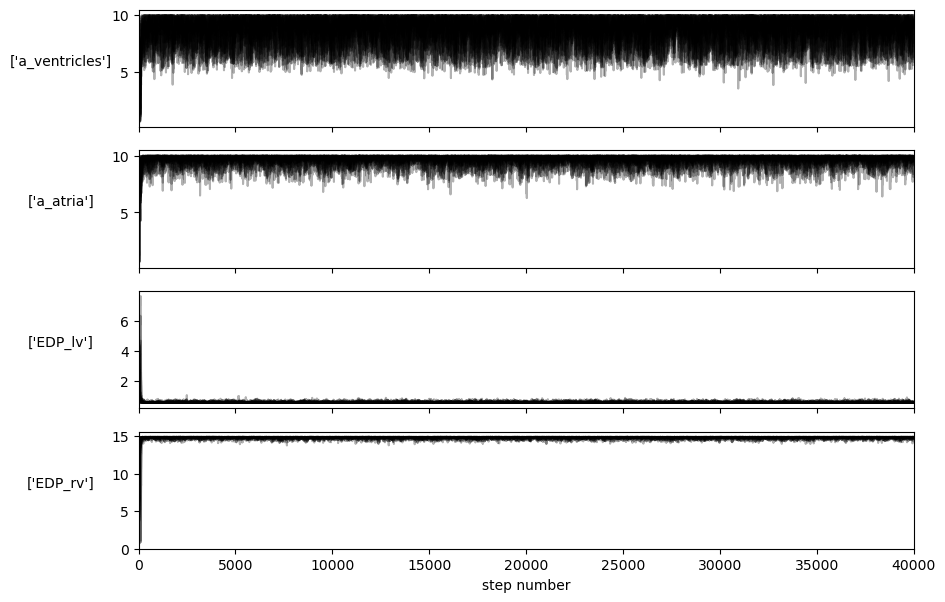

In [149]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [150]:
x_out = torch.tensor(flat_samples.mean(axis=0).T)


In [151]:
x_out.shape

torch.Size([4])

In [152]:
emulator.predict(x_out[None,:])

tensor([[101.1275,  64.7879,   0.1483]], grad_fn=<PermuteBackward0>)

In [153]:
torch.tensor(flat_samples.T).shape

torch.Size([4, 36000])

(array([9.1610e+03, 1.2738e+04, 7.0770e+03, 3.6770e+03, 1.9930e+03,
        9.0000e+02, 3.7300e+02, 6.8000e+01, 1.1000e+01, 2.0000e+00]),
 array([0.14557832, 0.1470903 , 0.14860229, 0.15011427, 0.15162624,
        0.15313822, 0.15465021, 0.15616219, 0.15767416, 0.15918615,
        0.16069813]),
 <BarContainer object of 10 artists>)

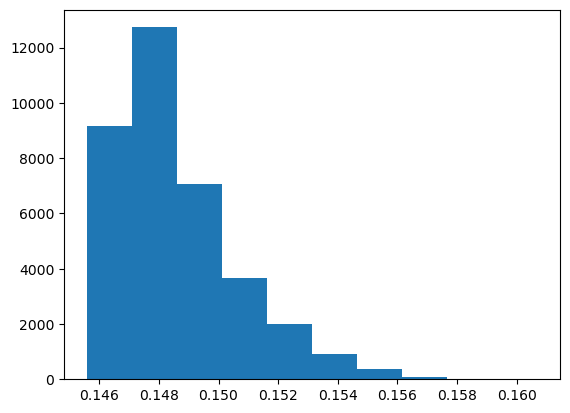

In [154]:
plt.hist(emulator.predict(torch.tensor(flat_samples))[:,2].detach().numpy())

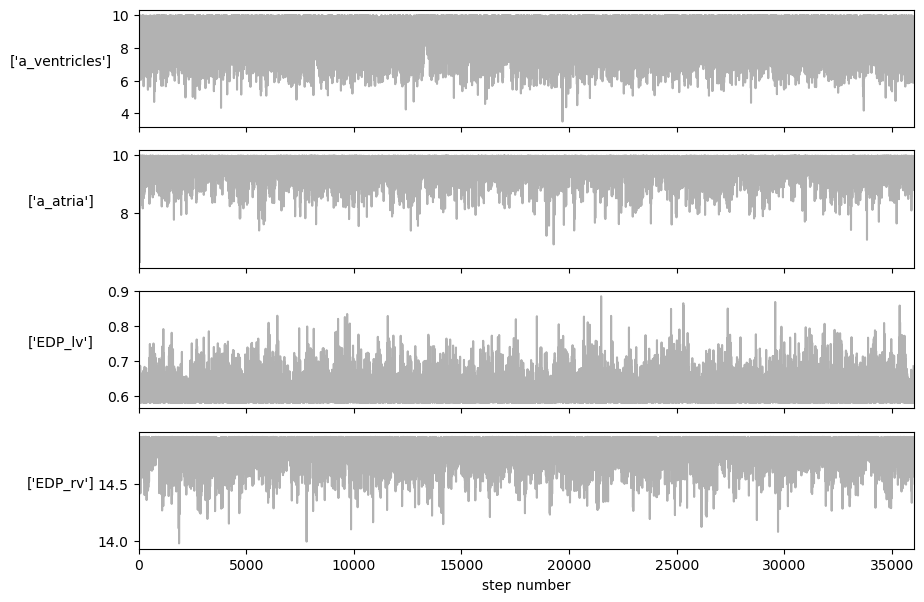

In [155]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [156]:
working = model.predict(flat_samples)

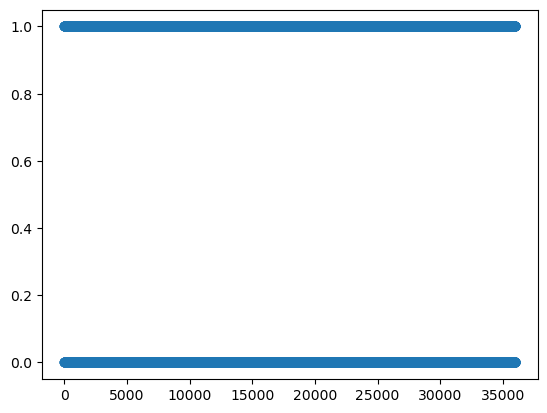

In [157]:
plt.plot(working,'o')

# Calibration with fixed inputs

In [ ]:
new_input=input_masked.copy()
new_input=new_input.drop(['CV_atria','a_atria','a_ventricles'],axis=1)

In [ ]:
emulator = GPE.ensemble(new_input,y_calibration,mean_func="linear",training_iter=500)

In [ ]:
nDim = new_input.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(new_input.iloc[:,i]),np.max(new_input.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [ ]:
nDim

In [ ]:
import emcee
ndim = nDim
nwalkers = 16
p0 = np.random.multivariate_normal(centre, 0.001*np.identity(ndim), size=(nwalkers))
y_val = [100,157,111,0.5]

In [ ]:
x_labels.values.squeeze().tolist()

In [ ]:
new_input.columns

In [ ]:
def log_likelihood(x,emulator,y_val):
    x=pd.DataFrame(x).T
    x.columns = new_input.columns.values.squeeze().tolist()
    y_val = pd.DataFrame(y_val).T
    y_val.columns = y_calibration.columns.values.squeeze().tolist()
    ll =np.sum(emulator.ensemble_log_likelihood(x,y_val))
    return ll

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [ ]:
sampler.run_mcmc(p0, 30000)

In [ ]:
flat_samples = sampler.get_chain(discard=6000, thin=10, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [ ]:
samp = pd.DataFrame(flat_samples).sample(50)

In [ ]:
samp.to_csv("MCMC_samples_scenario_5_90.dat", sep = " ",index=False,header=None)

In [ ]:
flat_samples.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [ ]:
x_out = pd.DataFrame(flat_samples.mean(axis=0)).T
x_out.columns = new_input.columns.values.squeeze()

In [ ]:
y_calibration.columns

In [ ]:
emulator.predict(x_out)

In [ ]:
plt.hist(emulator.predict(pd.DataFrame(flat_samples,columns=input_masked.columns))[:,3].detach().numpy())

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = flat_samples
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

# Multi-Output GP

In [ ]:
import mogptk

In [ ]:
y_calibration

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_calibration
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration2.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_calibration2.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=4)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='Adam', lr=0.1, iters=7000, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

In [ ]:
emulator.MSE(X_test,y_test)

In [ ]:
model.plot_correlation()

In [ ]:
model.print_parameters()

In [ ]:
params?

In [ ]:
params = []

for p in model.parameters():
    params.append(p)

In [ ]:
params

In [ ]:
plt.imshow([[0.0009756545815890106, 0.0, 0.0, 0.0, 27819.543719613113, 0.0, 0.0, 0.0], [1.7460115277182566, 0.0, 0.0, 119410.25481699423, 0.0, 0.0, 0.0, 0.0], [11.369120898808664, 115237.02973475368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6990749064961943, 0.0, 0.0, 74757.56112865475, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
plt.imshow([[10.162908005474888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.97208882285453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [35.583222651507306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.01360765548753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [ ]:
# split original dataset in training, validation and testing sets
X=input_masked
y=y_all
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [ ]:
MOData = pd.concat((X_train,y_train),axis=1)


In [ ]:
MOData

In [ ]:
y_calibration.columns.values.tolist()

In [ ]:
dataset = mogptk.LoadDataFrame(MOData,x_col=input_masked.columns.values.tolist(),y_col=y_all.columns.values.tolist())
dataset.transform(mogptk.TransformNormalize)
dataset

In [ ]:
dataset.get_test_data()

In [ ]:
# create model, uncomment for different kernels 
#model = mogptk.MOSM(dataset, Q=2)
#model = mogptk.CSM(dataset, Q=4)
#model = mogptk.SM_LMC(dataset, Q=4)
model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using LombScargle
model.init_parameters(method='LS', iters=500)

In [ ]:
model.train(method='SGD', lr=0.01, iters=3500, plot=True, error='MSE', verbose=True);

In [ ]:
model.train(method='SGD', lr=0.01, iters=500, plot=True, error='MSE', verbose=True);

In [ ]:
model.predict(X_test.values)[1]

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
model.plot_correlation()

In [ ]:
fig, ax = model.plot_correlation(figsize=(25, 25))

In [ ]:
start=time.time()
emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

end = time.time()
print(end - start)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
X_test

In [ ]:
import cigp_v10 as cig

In [ ]:
model = cig.cigp(torch.tensor(X_train.values),torch.tensor(y_train.values),normal_y_mode=1)

In [ ]:
import time
start = time.time()


model.train_adam(niteration=500)



In [ ]:
(torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]

In [ ]:
mogptMSE = np.array([9.10333333e-01, 1.33455636e-02, 8.78157403e-01, 6.69582124e-01,
       3.70024071e+02, 1.23460430e+02, 6.35753356e-01, 6.52791491e-04,
       3.76409392e-01, 5.31805275e-01, 1.71110574e+02, 5.49810697e+00,
       1.05649088e-01, 7.97417780e-02, 1.55348111e-01, 1.24083716e-02,
       5.45010526e-02, 5.65038223e-02, 1.02820944e-01, 1.11955787e-03,
       2.06413166e-02, 1.92173725e-02, 5.43121107e-02, 2.30204748e-02,
       1.96869906e-02, 1.69456459e-02, 1.63021757e+01, 1.57392304e+00])

In [ ]:
GPMSE = emulator.MSE(X_test,y_test).detach().numpy()
CIGMSE=((torch.sum((model.forward(torch.tensor(X_test.values))[0]-torch.tensor(y_test.values))**2,axis=0))/y_test.values.shape[0]).detach().numpy()

In [ ]:
fig, ax = plt.subplots()



im=plt.plot(1-GPMSE/np.var(y_test,axis=0),'o')
plt.plot(1-mogptMSE/np.var(y_test,axis=0),'o')
plt.plot(1-CIGMSE/np.var(y_test,axis=0),'o')
plt.legend(('GP','MOGPT','CIGP'))


plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [ ]:
np.mean((y_test.values.T-model.predict(X_test.values)[1])**2,axis=1)/X_test.shape[0]

In [ ]:
np.var(y_test,axis=0)

In [ ]:
y_all.iloc[:,[4]].max()

In [ ]:
y_all.iloc[:,[4]].min()

In [ ]:
y_all.iloc[:,[4]].std()